<font color="#de3023"><h1><b>REMINDER: MAKE A COPY OF THIS NOTEBOOK, DO NOT EDIT</b></h1></font>

# Introduction to Yelp Review Sentiment Classification

In this project, we will build a classifier that can predict a user's rating of a given restaurant from their review. This is an example of **sentiment analysis**: being able to quantify an individual's opinion about a particular topic merely from the words they use. 

**Discuss:** Can you think of other ways companies might use sentiment analysis?

In this notebook, we'll:


*   Explore the Yelp review dataset
*   Preprocess and vectorize our text data for NLP
*   Train a sentiment analysis classifier with logistic regression
*   (Optional) Explore and improve our model
*   (Optional, Advanced) Train a model with word embeddings
*   (Optional, Challenge) Use word embeddings to calculate similarity and analogies

Let's dive in!




![Example of a Yelp review](https://wordstream-files-prod.s3.amazonaws.com/s3fs-public/styles/simple_image/public/images/yelp-reviews-filtered.png)

In [ ]:
#@title Import our libraries (this may take a minute or two)
import pandas as pd   # Great for tables (google spreadsheets, microsoft excel, csv). 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import spacy
import wordcloud
import os # Good for navigating your computer's files 
import sys
pd.options.mode.chained_assignment = None #suppress warnings

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from spacy.lang.en.stop_words import STOP_WORDS
nltk.download('wordnet')
nltk.download('punkt')

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
!python -m spacy download en_core_web_md
import en_core_web_md
text_to_nlp = en_core_web_md.load()



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 96.4MB 1.2MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp37-none-any.whl size=98051304 sha256=7b1d77d9284e272f4c2c35ab5e60c61d104a432b75aa241ffc6c4cd00b426d91
  Stored in directory: /tmp/pip-ephem-wheel-cache-rescsryp/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
#@title Import our data

# import gdown
#gdown.download('https://drive.google.com/uc?id=1u0tnEF2Q1a7H_gUEH-ZB3ATx02w8dF4p', 'yelp_final.csv', True)
data_file  = 'yelp_final.csv'

!wget https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Session%203%20-%20NLP/yelp_final.csv


--2021-06-24 18:28:05--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Session%203%20-%20NLP/yelp_final.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.141.128, 142.250.101.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 760976 (743K) [text/csv]
Saving to: ‘yelp_final.csv’

yelp_final.csv      100%[===================>] 743.14K  --.-KB/s    in 0.005s  

2021-06-24 18:28:05 (144 MB/s) - ‘yelp_final.csv’ saved [760976/760976]



# Data Exploration

First we read in the file containing the reviews and take a look at the data available to us.

In [ ]:
# read our data in using 'pd.read_csv('file')'
yelp_full = pd.read_csv(data_file)
yelp_full.head()

,business_id,stars,text,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,5,My wife took me here on my birthday for breakf...,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,5,I have no idea why some people give bad review...,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,_1QQZuf4zZOyFCvXc0o6Vg,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",uZetl9T0NcROGOyFfughhg,1,2,0
3,6ozycU1RpktNG2-1BroVtw,5,General Manager Scott Petello is a good egg!!!...,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0
4,zp713qNhx8d9KCJJnrw1xA,5,Drop what you're doing and drive here. After I...,wFweIWhv2fREZV_dYkz_1g,7,7,4


**Discuss:**
- Which column gives us our output: the user's sentiment? 
- Which column gives us our input: the review?
- Why aren't businesses' and users' real names included? (You'll notice they're replaced with random strings through [hashing](https://medium.com/tech-tales/what-is-hashing-6edba0ebfa67)). Why aren't the real names included?

Let's keep only the two columns we need:



In [ ]:
needed_columns = ['text', 'stars'] #YOUR CODE HERE: fill in the columns
yelp = yelp_full[needed_columns]
yelp.head()

,text,stars
0,My wife took me here on my birthday for breakf...,5
1,I have no idea why some people give bad review...,5
2,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",5
3,General Manager Scott Petello is a good egg!!!...,5
4,Drop what you're doing and drive here. After I...,5


The text column is the one we are primarily focused with. Let's take a look at a few of these reviews to better understand our problem.

In [ ]:
#@title Check out the text in differently rated reviews
num_stars =  1#@param {type:"integer"}

for t in yelp[yelp['stars'] == num_stars]['text'].head(20).values:
    print (t) 

U can go there n check the car out. If u wanna buy 1 there? That's wrong move! If u even want a car service from there? U made a biggest mistake of ur life!! I had 1 time asked my girlfriend to take my car there for an oil service, guess what? They ripped my girlfriend off by lying how bad my car is now. If without fixing the problem. Might bring some serious accident. Then she did what they said. 4 brand new tires, timing belt, 4 new brake pads. U know why's the worst? All of those above I had just changed 2 months before!!! What a trashy dealer is that? People, better off go somewhere!
Disgusting!  Had a Groupon so my daughter and I tried it out.  Very outdated and gaudy 80's style interior made me feel like I was in an episode of Sopranos.  The food itself was pretty bad.  We ordered pretty simple dishes but they just had no flavor at all!  After trying it out I'm positive all the good reviews on here are employees or owners creating them.
I've eaten here many times, but none as bad

**Discuss:**


*   What words are often used in highly rated reviews?
*   What words are often used in low-rated reviews?
*   Do you notice any interesting exceptions? (For example, "The seating and ambience were impressive, but the food served to us was not")


#### Word Clouds

Another way to take a look at the most prominent words in any given star rating is through the use of word clouds. 

Edit the value in the cell below to see the word cloud for each star rating.

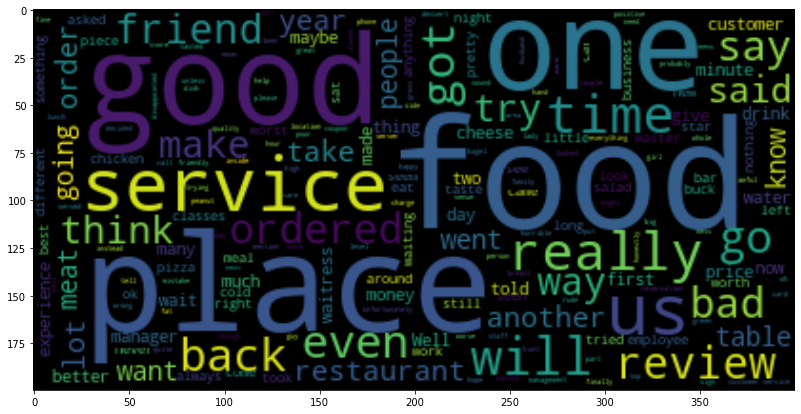

In [ ]:
#@title Word cloud for differently rated reviews
num_stars =  1#@param {type:"integer"}
this_star_text = ''
for t in yelp[yelp['stars'] == num_stars]['text'].values: # form field cell
    this_star_text += t + ' '
    
wordcloud = WordCloud()    
wordcloud.generate_from_text(this_star_text)
plt.figure(figsize=(14,7))
plt.imshow(wordcloud, interpolation='bilinear')

**What are the differences between the reviews that have 1, 2, 3, 4, and 5 stars?**

Any surprising similarities? 


### Exercise: Rules for Sentiment Analysis

Can you think of any combinations of words, or rules, that would indicate if a particular review is **postive** or **negative**? Note them down below:




In [ ]:
#@title Rules
rule_1 = "bad/great" #@param {type:"string"}
rule_2 = "gross/love" #@param {type:"string"}
rule_3 = "sucks/amazing" #@param {type:"string"}

**Discuss: will rules like this work well?**

It might not be enough to just see **whether** particular words are used! We also should look at **how much** they're used: the *number* of particular words might give us information about the user's opinion.


# Preparing Our Data for Machine Learning

Of course, it's much more efficient to use machine learning to analyze our text than try to create rules by hand! 

We'll need to prepare our data to use logistic regression. First, let's prepare our output column:

### Exercise: Preparing to Classify
We're going to try to predict the sentiment - **positive** or **negative** - based on a review's text. 

In order to reduce our problem to a **binary classification** (two classes) problem, we will:

 - label 4 and 5 star reviews as 'good'
 - label 1, 2, 3 star reviews as 'bad'

Please complete the function below and run it to create a new `is_good_review` column!

In [ ]:
def is_good_review(num_stars):
    if num_stars>=4: ### YOUR CODE HERE
        return True
    else:
        return False

# Change the stars column to either be 'good' or 'bad'.
yelp['is_good_review'] = yelp['stars'].apply(is_good_review)
yelp.head()

,text,stars,is_good_review
0,My wife took me here on my birthday for breakf...,5,True
1,I have no idea why some people give bad review...,5,True
2,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",5,True
3,General Manager Scott Petello is a good egg!!!...,5,True
4,Drop what you're doing and drive here. After I...,5,True


## Text Preprocessing: A Preview

Now, the trickier part: preparing our text input.

We'll need a few steps to preprocess our text and represent it numerically. **Why do we need to represent our text as numbers?**

We'll talk through all the steps here, then use a single function to implement them.

## Tokenization

First of all, we would like to **tokenize** each review: convert it from a single string into a list of words. Enter some example text into the cell below to see the tokenized version.

In [ ]:
#@title Basic tokenization example
example_text = "Hi I am Neal" #@param {type:"string"}
tokens = word_tokenize(example_text)
tokens

['Hi', 'I', 'am', 'Neal']

## Stopwords

Next, let's remove **stopwords**: words which are there to provide grammatical structure, but don't give us much information about a review's sentiment.

Edit the cell below to see if we're considering a given word as a stopword! Do you agree with the results?

In [ ]:
#@title Check if a word is a stop word
example_word = "The" #@param {type:'string'}
if example_word.lower() in STOP_WORDS:
  print ('"' + example_word + '" is a stop word.')
else:
  print ('"' + example_word + '" is NOT a stop word.')

"The" is a stop word.


We're going to remove these stopwords from the user reviews.

Tokenization and removal of stop words are universal to nearly every NLP application. In some cases, additional cleaning may be required (for example, removal of proper nouns, removal of digits) but we can build a text preprocessing function with these "base" cleaning steps.

Putting all these together, we can come up with a text cleaning function that we can apply to all of our reviews.

## Vectors

Finally, we'll need to convert our text to **vectors**, or lists of numbers. We'll start off doing this with Bag of Words, but we'll talk about another approach later!


### Bag of Words

In a **bag of words** approach, we count how many times each word was used in each review.

Suppose we want to represent two **reviews**: 
- "The food was great. The ambience was also great."
- "Great ambience, but not great food!"

First we define our vocabulary. This is *each unique word* in the review. So our **vocabulary** is: 
- [also, ambience, but, food, great, not, the, was].

Next, we count up how many times each word was used! (You can also think of this as adding up one-hot encodings.)

Our reviews are encoded as:
- **First review:** [1, 1, 0, 1, 2, 0, 2, 2]. Can you explain why?
- **Second review:** [_, _, _, _, _, _, _, _] Fill it in here! 



## Preprocessing Our Text in Action

Let's use bag-of-words to prepare our data! 

First, let's select our input *X* and output *y*:

In [ ]:
X_text = yelp['text']
y = yelp['is_good_review']

Now, let's prepare our data! First, we'll use CountVectorizer, a useful tool from Scikit-learn, to: 
*   Tokenize our reviews
*   Remove stopwords
*   Prepare our vocabulary


In [ ]:
#@title Initialize the text cleaning function { display-mode: "form" }
def tokenize(text):
    clean_tokens = []
    for token in text_to_nlp(text):
        if (not token.is_stop) & (token.lemma_ != '-PRON-') & (not token.is_punct): # -PRON- is a special all inclusive "lemma" spaCy uses for any pronoun, we want to exclude these 
            clean_tokens.append(token.lemma_)
    return clean_tokens

The cell below will take a moment! **Can you guess what `max_features` is for?**


In [ ]:
bow_transformer = CountVectorizer(analyzer=tokenize, max_features=800).fit(X_text)

Now, we can see our entire vocabulary! Can you guess what the numbers represent?

In [ ]:
bow_transformer.vocabulary_

{'\n': 0,
 '\n\n': 1,
 ' ': 2,
 ' \n': 3,
 ' \n\n': 4,
 '  ': 5,
 '$': 6,
 '+': 7,
 '1': 8,
 '1/2': 9,
 '10': 10,
 '12': 11,
 '15': 12,
 '2': 13,
 '20': 14,
 '25': 15,
 '3': 16,
 '30': 17,
 '4': 18,
 '5': 19,
 '50': 20,
 '6': 21,
 '7': 22,
 '8': 23,
 '9': 24,
 '=': 25,
 'AZ': 26,
 'Arizona': 27,
 'BBQ': 28,
 'Burger': 29,
 'Chandler': 30,
 'Chicken': 31,
 'Chili': 32,
 'Day': 33,
 'Food': 34,
 'Friday': 35,
 'Green': 36,
 'Grill': 37,
 'Happy': 38,
 'Hour': 39,
 'Mesa': 40,
 'New': 41,
 'Old': 42,
 'Phoenix': 43,
 'Saturday': 44,
 'Scottsdale': 45,
 'Service': 46,
 'Sunday': 47,
 'Tempe': 48,
 'Thai': 49,
 'Town': 50,
 'Valley': 51,
 'Yelp': 52,
 'able': 53,
 'absolutely': 54,
 'actually': 55,
 'add': 56,
 'admit': 57,
 'adult': 58,
 'afternoon': 59,
 'ago': 60,
 'agree': 61,
 'amazing': 62,
 'ambiance': 63,
 'app': 64,
 'appetizer': 65,
 'area': 66,
 'arrive': 67,
 'art': 68,
 'asada': 69,
 'asian': 70,
 'ask': 71,
 'atmosphere': 72,
 'attention': 73,
 'attentive': 74,
 'authentic': 7

The number represents the **index** (alphabetical position) of a word in the vocabulary.

By the way, how many words do we have?


In [ ]:
len(bow_transformer.vocabulary_)

800

It's the same as `max_features`! Is that a coincidence? What's the point of `max_features`?

Now that our vocabulary is ready, we can **transform** each review into a bag of words.



In [ ]:
X = bow_transformer.transform(X_text)

Finally, we've converted our reviews to numerical data that we can use in a logistic regression!

We can see what `X` looks like by printing it out as a DataFrame. **How long is each review's vector?** Why?

In [ ]:
pd.DataFrame(X.toarray())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799
0,0,3,8,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,3,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
996,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
997,0,11,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,9,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0,1,0,1,0,1,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Interlude: Word Embeddings

By the way, there's another way we could have converted our text to vectors: using **word embeddings** like Word2Vec. 

Let's explore word embeddings using a library called Spacy, which comes built-in with lots of useful information about the English language. Let's prepare a useful function from Spacy:

In [ ]:
text_to_nlp = en_core_web_md.load() #Prepare Spacy

`text_to_nlp` lets us find lots of information about a sentence. For example, we can pick out a specific word:

In [ ]:
doc = text_to_nlp(u"I like apples and cherries and peaches and pie")
token = doc[2] #Try changing this!
print (token)
print (len(token))

apples
6


We can also find the **word embedding** for each word: a 300-dimensional vector that captures the word's meaning!

In [ ]:
print ('Vector for: ', token)
print (token.vector) 

Vector for:  apples
[-0.6334     0.18981   -0.53544   -0.52658   -0.30001    0.30559
 -0.49303    0.14636    0.012273   0.96802    0.0040354  0.25234
 -0.29864   -0.014646  -0.24905   -0.67125   -0.053366   0.59426
 -0.068034   0.10315    0.66759    0.024617  -0.37548    0.52557
  0.054449  -0.36748   -0.28013    0.090898  -0.025687  -0.5947
 -0.24269    0.28603    0.686      0.29737    0.30422    0.69032
  0.042784   0.023701  -0.57165    0.70581   -0.20813   -0.03204
 -0.12494   -0.42933    0.31271    0.30352    0.09421   -0.15493
  0.071356   0.15022   -0.41792    0.066394  -0.034546  -0.45772
  0.57177   -0.82755   -0.27885    0.71801   -0.12425    0.18551
  0.41342   -0.53997    0.55864   -0.015805  -0.1074    -0.29981
 -0.17271    0.27066    0.043996   0.60107   -0.353      0.6831
  0.20703    0.12068    0.24852   -0.15605    0.25812    0.007004
 -0.10741   -0.097053   0.085628   0.096307   0.20857   -0.23338
 -0.077905  -0.030906   1.0494     0.55368   -0.10703    0.052234
  0.4

#### Exercise: Exploring Similarity

A neat thing you can do with word embeddings is calculate similarity, like this:

```
doc = text_to_nlp(u"keyboard and mouse")
word1 = doc[0]
word2 = doc[2]
word1.similarity(word2)
```

Using the example above, try to find **two words with similarity greater than .80** and **two words with similarity less than .15**!

In [ ]:
### YOUR CODE HERE
doc = text_to_nlp("hi and might")
word1 = doc[0]
word2 = doc[2]
word1.similarity(word2)

### END CODE

0.23116446

Check out the challenge exercises if you're interested in exploring word embeddings further with our Yelp dataset.

# Creating a Baseline Classifier

Now, back to our sentiment analysis problem! Our data is ready for machine learning.

Our classification problem is a classic two-class classification problem, and so we will use the tried-and-tested **Logistic Regression** machine learning model.

As always, we'll start by setting aside testing and training data:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

###Exercise: Training your Model
Now, we can create and train our model! Please **fill in the code to train (or *fit*) your model**.

(Need a hint? Refer to last time's notebook or Scikit-learn documentation if needed.)

In [ ]:
logistic_model = LogisticRegression()

#YOUR CODE HERE to train the model (1 line)
logistic_model.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

###Exercise: Testing Your Model
Now, let's evaluate our model's accuracy! Your model needs to **predict** the sentiment, and then you'll **calculate the accuracy** using `accuracy_score`. **Which dataset** should you use?

In [ ]:
y_pred = logistic_model.predict(X_test) #YOUR CODE HERE
accuracy = accuracy_score(y_pred, y_test) #YOUR CODE HERE
print (accuracy)

0.77


Congratulations - you've trained and tested your model! It's not perfect, but a whole lot better than a coin flip :)


#Optional: Exploring Your Model

Let's explore your model in more depth.

###Exercise: Trying Out Reviews

Accuracy only tells us so much! It's often useful to figure out **what sorts** of mistakes your model makes. 

Try enterning some reviews below and explore:

*   What kind of reviews does your model classify correctly? For example, do long or short reviews work better?
*   What kind of reviews does your model get wrong? Does it understand sarcasm or other "tricky" language?
*   Does it seem like your model pays attention to particular words?



In [ ]:
#@title Enter a review to see your model's classification
example_review = "" #@param {type:'string'}
prediction = logistic_model.predict(bow_transformer.transform([example_review]))

if prediction:
  print ("This was a GOOD review!")
else:
  print ("This was a BAD review!")



This was a BAD review!


###Exercise: Changing the Vocabulary Size


Experiment with changing the `max_features` attribute when you created the bag of words model: the maximum size of the vocabulary. Then re-train your model (you might find "Runtime > Run after" useful.) 

Discuss: how does this change affect the accuracy of your model? Why?

###Exercise: Using a Different Classifier

We used logistic regression for our baseline model, but there are many other classifier models we could use!

One common model is called Multinomial Naive Bayes. Naive Bayes uses Bayes' Theorem of probability to predict the class of new input data. The important assumption that Naive Bayes makes is that all the features are independent: the number of times a review uses "potato" is unrelated to the number of times a review uses "server". (Do you think this is an accurate assumption??)

Let's build a model using a Naive Bayes classifier!

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()

We can train and generate predictions from this model in the same way we did for our Logistic Regression model. Try training this model on the same data and see if it performs better or worse than our logistic regression model. Then, evaluate the model accuracy as you did for the Logistic Regression classifier.



In [ ]:
###YOUR CODE HERE####
nb_model.fit(X_test, y_test)
y_pred = nb_model.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print(accuracy)

0.95


Experiment with [other models](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) to try to get the highest accuracy!

In [ ]:
###YOUR CODE HERE###
from sklearn import tree
new_model = tree.DecisionTreeClassifier(max_depth=8)
new_model.fit(X_train, y_train)
y_pred = new_model.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print(accuracy)

0.635


# Optional (Advanced): Training Logistic Regression with Word Embeddings

As we've discussed, there's an alternative to bag-of-words: we can use word embeddings to get more sophisticated representations of our reviews. Let's try it out!


We'll use this helper function to remove stop words, pronouns, and punctuation, and convert each word to a spaCy object (we can use `token.vector` later).

In [ ]:
def tokenize_vecs(text):
    clean_tokens = []
    for token in text_to_nlp(text):
        if (not token.is_stop) & (token.lemma_ != '-PRON-') & (not token.is_punct): 
          # -PRON- is a special all inclusive "lemma" spaCy uses for any pronoun, we want to exclude these 
            clean_tokens.append(token)
    return clean_tokens

We want to represent each Yelp review with a vector. Since each review consists of multiple words, we want to find a way to create one vector for each review. 

Would adding the word vectors work? What about averaging? Which would be preferrable?

Implement your solution below: convert our array of reviews into an array of vector representations of those reviews.

In [ ]:
X_word2vec = []
for text in X_text:
  review = tokenize_vecs(text) # returns cleaned list of spacy tokens
  #### YOUR CODE HERE
  review_vec = [0]*300
  for word in review:
    review_vec+=word.vector
  review_vec = review_vec/len(review)
  X_word2vec.append(review_vec)
  #### END CODE
  
X_word2vec = np.array(X_word2vec)

Now, test and train a logistic regression mode! Remember to create new training and testing data using `X_word2vec`.

In [ ]:
#YOUR CODE HERE
X_train, X_test, y_train, y_test = train_test_split(X_word2vec, y, test_size=0.2, random_state=101)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_train)
accuracy = accuracy_score(y_pred, y_train)
print(accuracy)


0.8425


**Discuss:** Can you explain the results? 

# Optional (Challenge): Word Embedding Math

(Heads-up: this challenge section is math-heavy!)

One reason text embeddings are cool is that we can use them to explore connections in meaning between different words, including calculating similarity between words and completing [analogies](http://bionlp-www.utu.fi/wv_demo/).

We'll start by creating a dictionary containing the vectors for all the words in our vocabulary. We'll stick to the vocabulary above of 800 words from the Yelp reviews - if you want to use more words, change that number! 

In [ ]:
vocab_dict = dict() #initialize dictionary

for word in bow_transformer.vocabulary_:
    vocab_dict[word] = text_to_nlp(word).vector # What is the key? What is the value?

for word, vec in vocab_dict.items(): # Iterating through the dictionary to print each key and value
  print ('Word: {}. Vector length: {}'.format(word, len(vec)))

print()
print ('{} words in our dictionary'.format(len(vocab_dict)))

Word: wife. Vector length: 300
Word: take. Vector length: 300
Word: birthday. Vector length: 300
Word: breakfast. Vector length: 300
Word: excellent. Vector length: 300
Word:  . Vector length: 300
Word: perfect. Vector length: 300
Word: sit. Vector length: 300
Word: outside. Vector length: 300
Word: waitress. Vector length: 300
Word: food. Vector length: 300
Word: arrive. Vector length: 300
Word: quickly. Vector length: 300
Word: busy. Vector length: 300
Word: Saturday. Vector length: 300
Word: morning. Vector length: 300
Word: look. Vector length: 300
Word: like. Vector length: 300
Word: place. Vector length: 300
Word: fill. Vector length: 300
Word: pretty. Vector length: 300
Word: well. Vector length: 300
Word: 

. Vector length: 300
Word: simply. Vector length: 300
Word: good. Vector length: 300
Word: sure. Vector length: 300
Word: use. Vector length: 300
Word: ingredient. Vector length: 300
Word: fresh. Vector length: 300
Word: order. Vector length: 300
Word: amazing. Vector length

Next, let's calculate the similarity between two words, using their Word2Vec representations.

A common way to calculate the similarity between two vectors is called *cosine similarity*. It depends on the angle between those two vectors when plotted in space. As an example, imagine we had two three-dimensional vectors:

In [ ]:
v0 = [2,3,1]
v1 = [2,4,1]

Run the code below to plot those vectors, and try changing the numbers above.
How can you make a very small angle between the vectors? How can you make a very large angle?

In [ ]:
#@title Run this to create an interactive 3D plot
#Code from https://stackoverflow.com/questions/47319238/python-plot-3d-vectors 
import numpy as np 
import plotly.graph_objs as go

def vector_plot(tvects,is_vect=True,orig=[0,0,0]):
    """Plot vectors using plotly"""

    if is_vect:
        if not hasattr(orig[0],"__iter__"):
            coords = [[orig,np.sum([orig,v],axis=0)] for v in tvects]
        else:
            coords = [[o,np.sum([o,v],axis=0)] for o,v in zip(orig,tvects)]
    else:
        coords = tvects

    data = []
    for i,c in enumerate(coords):
        X1, Y1, Z1 = zip(c[0])
        X2, Y2, Z2 = zip(c[1])
        vector = go.Scatter3d(x = [X1[0],X2[0]],
                              y = [Y1[0],Y2[0]],
                              z = [Z1[0],Z2[0]],
                              marker = dict(size = [0,5],
                                            color = ['blue'],
                                            line=dict(width=5,
                                                      color='DarkSlateGrey')),
                              name = 'Vector'+str(i+1))
        data.append(vector)

    layout = go.Layout(
             margin = dict(l = 4,
                           r = 4,
                           b = 4,
                           t = 4)
                  )
    fig = go.Figure(data=data,layout=layout)
    fig.show()


vector_plot([v0,v1])

For our Word2Vec vectors, we can imagine doing the same thing in 300-dimensional space. Of course, it's much harder to plot that! [Here](https://projector.tensorflow.org/) is one representation that you can play around with.

Then we find the cosine of the angle between the two vectors to get the similarity. 

If the vectors are exactly the same, the angle will be 0, so we get a similarity of $cos(0) = 1$.

If the vectors are exactly opposite, the angle will be 180 degrees, so we get a similarity of $cos(180) = -1$.

There's a useful [mathematical trick](https://www.mathsisfun.com/algebra/vectors-dot-product.html) to find the cosine similarity:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/1d94e5903f7936d3c131e040ef2c51b473dd071d)

Where $A_1, A_2, ..., A_{300}$ are the elements of the first vector and $B_1, B_2, ..., B_{300}$ are the elements of the second vector.

Please implement cosine similarity below, and test it out using our 3-dimensional vectors from above. Do the results make sense?


In [ ]:
def vector_cosine_similarity(vec1,vec2):
  #YOUR CODE HERE
  pass
  #Return a number between -1 and 1

print(vector_cosine_similarity(v0,v1))

Now, use your cosine similarity function to calculate the similarity between two words. Try out a few words from the dataset - what pairs of words can you find that are particularly similar or particularly dissimilar?

In [ ]:
def word_similarity(word1, word2):
  #Should return a similarity between -1 and 1
  
  try:
    vec1 = vocab_dict[word1]
    vec2 = vocab_dict[word2]

    #TODO: Fill in the return statement here

  except KeyError:
    print ('Word not in dictionary')

print(word_similarity('burger','steak'))

Now, we can use our functions above to find the *most* similar words to any particular word. 

`find_most_similar(start_vec)` should output the top 5 words whose vectors are most similar to start_vec, with their similarities. Please fill it in.


In [ ]:
def find_nearest_neighbor(word):
  try:
    vec = vocab_dict[word]
    find_most_similar(vec)
  except KeyError:
    print ('Word not in dictionary')

def find_most_similar(start_vec):
  #Should print the top 5 most similar words to start_vec, and their similarities.,
  #Hint: use a for loop to iterate through vocab_dict.
  #Consider using a Pandas series.

  #YOUR CODE HERE
  pass
  
find_nearest_neighbor('bagel')

Finally, we can use the functions we've built to complete word analogies, like the ones you can try out [here](http://bionlp-www.utu.fi/wv_demo/). For example:

*   Breakfast is to bagel as lunch is to ________,

This requires a bit of "word arithmetic":
let's say A1, A2, and B1 are vectors for three words we know. We're trying to find B2 to complete 

*   A1 is to A2 as B1 is to B2.

Intuitively, this means that the difference between A1 and A2 is the same as the difference between B1 and B2. So we write

*   A1 - A2 = B1 - B2

**Solve for B2:**

*   B2 = ________________

Once we know the vector that we "expect" for B2, we can use our previous functions to find the word whose representation is closest to that vector. Try it out!

In [ ]:
def find_analogy(word_a1, word_a2, word_b1):
  #Convert the words to vectors a1, a2, b1
  #If word_a1:word_a2 as word_b1:word_b2, then 
  #a1 - a2 = b1 - b2
  #So b2 = ...
  #Calculate b2, and use your previous functions to find the best candidates for word_b2.

  #YOUR CODE HERE
  pass
  
find_analogy('breakfast','bagel','lunch')

Word arithmetic doesn't always work perfectly - it's pretty tricky to find good examples! Which can you discover?

If you're looking for a way to expand further on this exercise, you can try seeing what happens when you use [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance), another common measurement, instead of cosine similarity.